# belief_network_lib

# Example. Using Markov blanket to reduce 20 variables to 4 

#1 Introduction

We are interested in understanding the relationship between a variable X and a response variable Y. This is often done in the context of many (sometimes hundreds, thousands, or more) other variables. In general it is difficult to know if a change in Y was due to X2, and not another variable. Isolating the relationship between two variables might in general be accomplished by randomizing for the presence of the other variables. While in some circumstances this is feasible, when there are many (tens, hundreds, or thousands) of other variables, it is not feasible to acquire sufficient data to support this. If there is a way to reduce the complete set of variables, to a smaller set of variables that are most significant to Y, this would provide a smaller, more feasible set to randomize for. This smaller set of variables is precisely the Markov blanket for Y. 

In this example:
- We show how belief_network_lib identifies this smaller set of variables comprising the Markov blanket.
- We demonstrate that this significantly smaller set of variables contains the most important information to Y, by comparing a classifier of Y based upon all (20) variables, to one based on the four in the Markov blanket, and showing its (slightly) better performance. 

## 1.1 Example description

In this example, there are twenty variables:

Variables: X1, X2, X20, X21, X22, X23, X24, X3, X30, X31, X32, X33, X34, X4, X40, X41, X42, X43, X44

and one response variable, Y

Each of the variables is a binary variable, taking on the value 0 or 1.

In [532]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [533]:
import network
import network_learner

In [534]:
import pandas
from pandas import DataFrame, Series

In [535]:
import sklearn
import numpy as np

#2 Example

In [536]:
df = pandas.read_csv("./data_samples/nb_data.csv")

In [537]:
df.head()

,X1,X2,X20,X21,X22,X23,X24,X3,X30,X31,X32,X33,X34,X4,X40,X41,X42,X43,X44,Y
0,0,0,1,0,1,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0
1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0
2,0,1,1,0,0,1,1,0,0,1,1,1,0,0,0,0,1,1,0,0
3,1,0,1,0,1,1,0,0,0,0,0,1,0,1,0,1,0,1,0,0
4,0,0,1,0,1,1,0,0,0,0,1,1,1,0,0,1,0,0,1,0


##2.1 Find Markov blanket around Y

In [539]:
input_file = open("./data_samples/nb_data.csv")
aNL = network_learner.NetworkLearner(input_file)

In [540]:
aNL.find_markov_blanket_for("Y", significance=0.001)

{'X1', 'X2', 'X20', 'X3', 'X4'}

##2.2 Build classifier based on all 20 variables

###2.2.1 De-bias the data by making an even split between Y=0 and Y=1

In [541]:
indices =np.where(df.Y==0)[0]

In [542]:
to_keep = [random.choice(indices) for x in range(3508)]

In [543]:
neg_rows = [df[["X1", "X2", "X20", "X21", "X22", "X23", "X24", "X3", "X30", "X31", "X32", "X33", "X34", "X4", "X40", "X41", "X42", "X43", "X44"]].iloc[index] for index in to_keep]

In [544]:
df_neg_rows = DataFrame(neg_rows)

In [545]:
neg_feature_rows = df_neg_rows.as_matrix()

In [546]:
pos_indices = np.where(df.Y==1)[0]

In [547]:
pos_rows = [df[["X1", "X2", "X20", "X21", "X22", "X23", "X24", "X3", "X30", "X31", "X32", "X33", "X34", "X4", "X40", "X41", "X42", "X43", "X44"]].iloc[index] for index in pos_indices]

In [548]:
df_pos_rows = DataFrame(pos_rows)

In [549]:
pos_feature_rows = df_pos_rows.as_matrix()

In [550]:
data_set_df = df_neg_rows.append(df_pos_rows)

In [551]:
Y = [0 for x in range(3508)]

In [552]:
Y.extend([1 for x in range(3508)])

### Select training set

In [553]:
training_set_df = None

In [554]:
#Randomly select two-thirds of positive
pos_indices_train = numpy.random.choice(pos_indices, int(math.floor( (float(2)/3) *len(pos_indices))) , replace=False)

In [555]:
pos_rows_train = [df[["X1", "X2", "X20", "X21", "X22", "X23", "X24", "X3", "X30", "X31", "X32", "X33", "X34", "X4", "X40", "X41", "X42", "X43", "X44"]].iloc[index] for index in pos_indices_train]

In [556]:
df_pos_rows_train = DataFrame(pos_rows_train)

In [557]:
neg_indices = to_keep

In [558]:
#Randomly select two-thirds of negative
neg_indices_train = numpy.random.choice(neg_indices, int(math.floor( (float(2)/3) *len(neg_indices))), replace=False )

In [559]:
neg_rows_train = [df[["X1", "X2", "X20", "X21", "X22", "X23", "X24", "X3", "X30", "X31", "X32", "X33", "X34", "X4", "X40", "X41", "X42", "X43", "X44"]].iloc[index] for index in neg_indices_train]

In [560]:
df_neg_rows_train = DataFrame(neg_rows_train)

In [561]:
# Complete training set
training_set_df = df_neg_rows_train.append(df_pos_rows_train)

In [562]:
Y_train = [0 for x in range( len(neg_rows_train) )]

In [563]:
Y_train.extend([1 for x in range( len(pos_rows_train) )])

### Select test set

In [564]:
pos_indices_test = [index for index in pos_indices if index not in pos_indices_train]

In [565]:
pos_rows_test = [df[["X1", "X2", "X20", "X21", "X22", "X23", "X24", "X3", "X30", "X31", "X32", "X33", "X34", "X4", "X40", "X41", "X42", "X43", "X44"]].iloc[index] for index in pos_indices_test]

In [566]:
df_pos_rows_test = DataFrame(pos_rows_test)

In [567]:
neg_indices_test = [index for index in neg_indices if index not in neg_indices_train]

In [568]:
neg_rows_test = [df[["X1", "X2", "X20", "X21", "X22", "X23", "X24", "X3", "X30", "X31", "X32", "X33", "X34", "X4", "X40", "X41", "X42", "X43", "X44"]].iloc[index] for index in neg_indices_test]

In [569]:
df_neg_rows_test = DataFrame(neg_rows_test)

In [570]:
# Complete test set
test_set_df = df_neg_rows_test.append(df_pos_rows_test)

In [571]:
Y_test = [0 for x in range( len(neg_rows_test))]

In [572]:
Y_test.extend([1 for x in range( len(pos_rows_test))])

###2.2.2 Build classifier

In [573]:
from sklearn.linear_model import LogisticRegression

In [574]:
est = LogisticRegression()

In [575]:
est.fit(training_set_df.as_matrix(), Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

#### Measure test set accuracy

In [576]:
est.score(test_set_df.as_matrix(), Y_test)

0.88666999500748878

##2.3 Classifier based on 4 Markov blanket variables

In [577]:
train_vals_mb = training_set_df[["X1", "X2", "X3", "X4"]].as_matrix()

In [578]:
train_vals_mb

array([[0, 1, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 1],
       ..., 
       [0, 0, 1, 1],
       [0, 0, 1, 1],
       [0, 1, 0, 1]])

In [579]:
est2 = LogisticRegression()
est2.fit(train_vals_mb, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

### Measure test set accuracy

In [580]:
est2.score(test_set_df[["X1", "X2", "X3", "X4"]].as_matrix(), Y_test)

0.89365951073389915

## 2.4 Attempting dimensionality reduction via PCA instead

from sklearn.decomposition import PCA

In [581]:
pca = PCA()

In [582]:
pca.fit(training_set_df.as_matrix())

PCA(copy=True, n_components=None, whiten=False)

In [583]:
variances = pca.explained_variance_ratio_

## Plot variance as a function of principal components

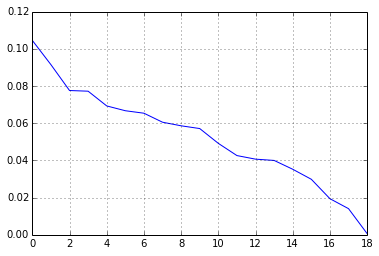

In [584]:
Series(variances).plot()

As can be seen in the figure above, the variance captured by the principal components does not exhibit a sharp drop off, as would be the case if the variables exhibited linear relationships with each other. The number of principal components that would have to be included in any basis transformation is nearly as many as the original 20 dimensions.